# 1. Path Setups

In [2]:
import os
import glob
import cv2 
import time
import base64
import requests
import numpy as np
import matplotlib.pyplot as plt
import imutils
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from roboflow import Roboflow
import json
from Labels import labels
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

In [ ]:
ROBOFLOW_API_KEY = "mAx8l6o3PPZKYQReFKQg"
ROBOFLOW_MODEL = "car-plates-jvked/3"
ROBOFLOW_SIZE = 416

In [2]:
paths = {
    'IMAGE_PATH': os.path.join('codes', 'workspace','images'),
 }

# 2. Image Preprocessing and Number Plate Recognition With YOLOv8 From RoboFlow

In [10]:
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace().project("car-plates-jvked")
model = project.version(3).model

loading Roboflow workspace...
loading Roboflow project...


In [3]:
ORIGINAL_IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates', '*ers.jpg')
ORIGINAL_IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates')
origina_image_paths = list(glob.glob(ORIGINAL_IMAGE_PATH))

In [33]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'plates', '*.jpg')
images_path= list(glob.glob(IMAGE_PATH))
images_path[-3:-1]
images_path = images_path[-3:-2]
images_path

['codes\\workspace\\images\\plates\\220px-Egyptian_license_plate_for_busses.jpg']

In [34]:
print(f'There are {len(images_path):,} images in the plates dataset')

There are 1 images in the plates dataset


1it [00:01,  1.44s/it]


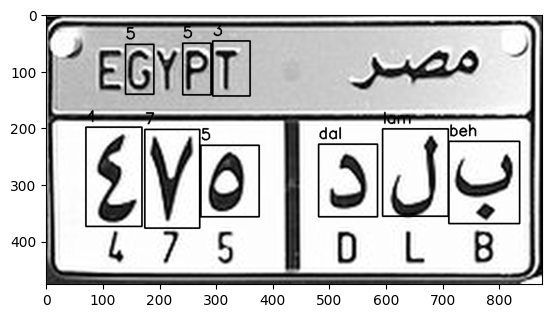

In [44]:
for i, image in tqdm(enumerate(images_path)):
    img = cv2.imread(image)
    img_scaled = cv2.resize(img, None, fx=4, fy=4, interpolation = cv2.INTER_LANCZOS4)
    gray_image = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray_image, (7,7), 0)

    _, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    y_hat= model.predict(th3, confidence=40, overlap=40).json()
    predictions = y_hat['predictions']


    # sort the predictions based on the `x` coordinate of each bounding box
    predictions_sorted = sorted(predictions, key=lambda x: x['x'],reverse=True)
    for i in range(len(predictions_sorted)):
        x, y, w, h = int(predictions_sorted[i]['x']), int(predictions_sorted[i]['y']), int(predictions_sorted[i]['width']), int(predictions_sorted[i]['height'])
        x_box, y_box = x - w//2, y - h//2 # Calculate the top-left corner of the bounding box
        cv2.rectangle(gray_image, (x_box, y_box), (x_box + w, y_box + h), (0, 255, 0), 2)
        class_text = predictions_sorted[i]['class']
        cv2.putText(gray_image, class_text, (x_box, y_box-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    plt.imshow(gray_image,cmap='gray')
    
        

In [23]:
upload_url = "".join([
    "https://detect.roboflow.com/",
    ROBOFLOW_MODEL,
    "?api_key=",
    ROBOFLOW_API_KEY,
    "&format=image",
    "&stroke=5"
])

# Get webcam interface via opencv-python

video = cv2.VideoCapture(0)
video.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*"H264"))
# Infer via the Roboflow Infer API and return the result
def infer(video):
    # Get the current image from the webcam
    # video = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    ret, img = video.read()

    # Resize (while maintaining the aspect ratio) to improve speed and save bandwidth
    height, width, channels = img.shape
    scale = ROBOFLOW_SIZE / max(height, width)
    img = cv2.resize(img, (round(scale * width), round(scale * height)))

    # Encode image to base64 string
    retval, buffer = cv2.imencode('.jpg', img)
    img_str = base64.b64encode(buffer)

    # Get prediction from Roboflow Infer API
    resp = requests.post(upload_url, data=img_str, headers={
        "Content-Type": "application/x-www-form-urlencoded"
    }, stream=True).raw

    # Parse result image
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    return image

# Main loop; infers sequentially until you press "q"
while True:
    start = time.time()
    video_thread = threading.Thread(target=infer(video))
    video_thread.start()
    
    # On "q" keypress, exit
    if cv2.waitKey(1) == ord('q'):
        break
        
    # Synchronously get a prediction from the Roboflow Infer API
    image = infer(video)
    
    # And display the inference results
    cv2.imshow('image', image)
    
    # Sleep for a short time to control the frame rate
    time.sleep(0.05)
    
    # Print frames per second
    print((1/(time.time()-start)), " fps")

# Release resources when finished
video.release()
cv2.destroyAllWindows()


Exception in thread Thread-15:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.3782100778556736  fps


Exception in thread Thread-16:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.3165403992949977  fps


Exception in thread Thread-17:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.48157207534483754  fps


Exception in thread Thread-18:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.49662681744367027  fps


Exception in thread Thread-19:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.488504951257285  fps


Exception in thread Thread-20:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5472821983857259  fps


Exception in thread Thread-21:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.595381627008664  fps


Exception in thread Thread-22:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.42097736552509507  fps


Exception in thread Thread-23:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5969678678362821  fps


Exception in thread Thread-24:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.37898452700439506  fps


Exception in thread Thread-25:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.49464066087882336  fps


Exception in thread Thread-26:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5557343681556812  fps


Exception in thread Thread-27:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.572862907752811  fps


Exception in thread Thread-28:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.554374456107405  fps


Exception in thread Thread-29:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.46872886458718416  fps


Exception in thread Thread-30:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.4955518173287841  fps


Exception in thread Thread-31:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5118146920926823  fps


Exception in thread Thread-32:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5416120014793174  fps


Exception in thread Thread-33:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5876285554449843  fps


Exception in thread Thread-34:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.6124877701161511  fps


Exception in thread Thread-35:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.6036117080671016  fps


Exception in thread Thread-36:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.49087769803706455  fps


Exception in thread Thread-37:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.6038956364287676  fps


Exception in thread Thread-38:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5807648398270017  fps


Exception in thread Thread-39:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.6212890888272352  fps


Exception in thread Thread-40:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.6125704244276664  fps


Exception in thread Thread-41:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


0.5878003411909845  fps


Exception in thread Thread-42:
Traceback (most recent call last):
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 980, in _bootstrap_inner
    self.run()
  File "c:\Users\Mahran\anaconda3\envs\Newenv\lib\threading.py", line 916, in run
    if self._target:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
